# Engineering gRNA Features

In this notebook, I'll go through all of the features I defined for each data point, looking both at how they're distributed across the dataset and how they're correlated to each other.

For more details, see the "Features" section of the [Main Presentation](main-presentation.ipynb).

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy
from guide.dataset import GuideDataset
from itertools import combinations
from guide.datapoint import feature_units
from guide.plot_helpers import *

In [2]:
# I created a wrapper class around the dataset and each point to make working with the data easier
guide_dataset = GuideDataset('data/example_guide_data_with_bowtie_with_mfold.tsv')
points = guide_dataset.points
points = list(filter(lambda p: p.mfold_result().dG < 900, points)) # remove a small number of bad points

In [3]:
# Plot helpers specific to this file
def feature_values(feature):
    return [getattr(p, feature)() for p in points]

def compare_features(feature1, feature2, bins=100, xrng=None):
    plt.hist2d(feature_values(feature1), feature_values(feature2), bins=bins, range=xrng)
    plt.title('{} vs {}'.format(feature1, feature2))
    plt.xlabel(feature_label(feature1))
    plt.ylabel(feature_label(feature2))
    colorbar = plt.colorbar()
    colorbar.set_label('number of points')

def compare_feature_combinations(features, fig):
    for feature1, feature2 in combinations(features, 2):
        fig.next_subplot()
        compare_features(feature1, feature2)

def feature_histogram(feature, bins=100, xrng=None):
    values = feature_values(feature)
    mean = numpy.mean(values)
    plt.hist(values, bins=bins, range=xrng)
    plt.title('{}, mean={}'.format(feature, round(mean, 2)))
    plt.axvline(mean, color='red')
    plt.xlabel(feature_label(feature))
    plt.ylabel('number of points')

def feature_histograms(features, fig):
    for feature in features:
        fig.next_subplot()
        feature_histogram(feature)

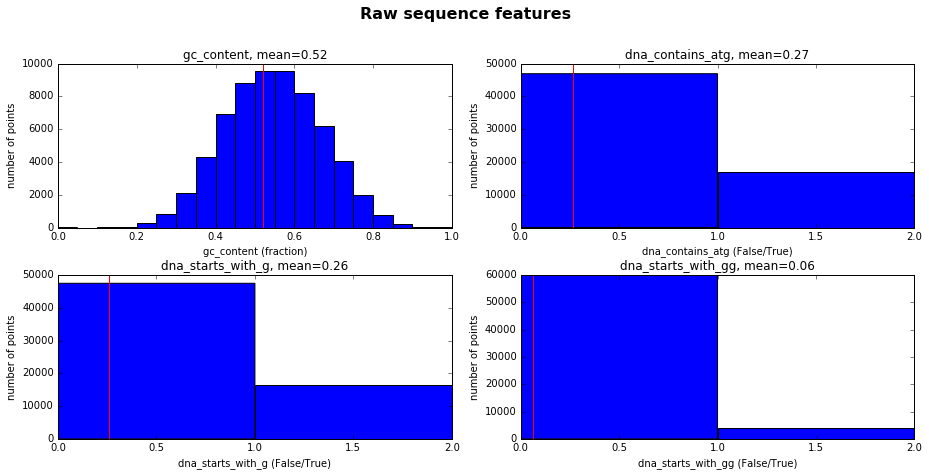

In [4]:
with figure_grid(2, 2, 'Raw sequence features') as fig:
    fig.next_subplot(); feature_histogram('gc_content', bins=20, xrng=(0,1))
    fig.next_subplot(); feature_histogram('dna_contains_atg', bins=2, xrng=(0,2))
    fig.next_subplot(); feature_histogram('dna_starts_with_g', bins=2, xrng=(0,2))
    fig.next_subplot(); feature_histogram('dna_starts_with_gg', bins=2, xrng=(0,2))

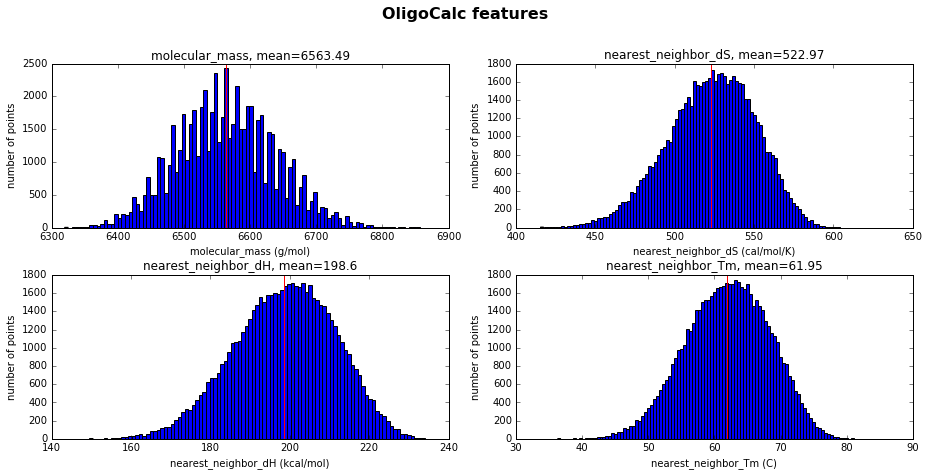

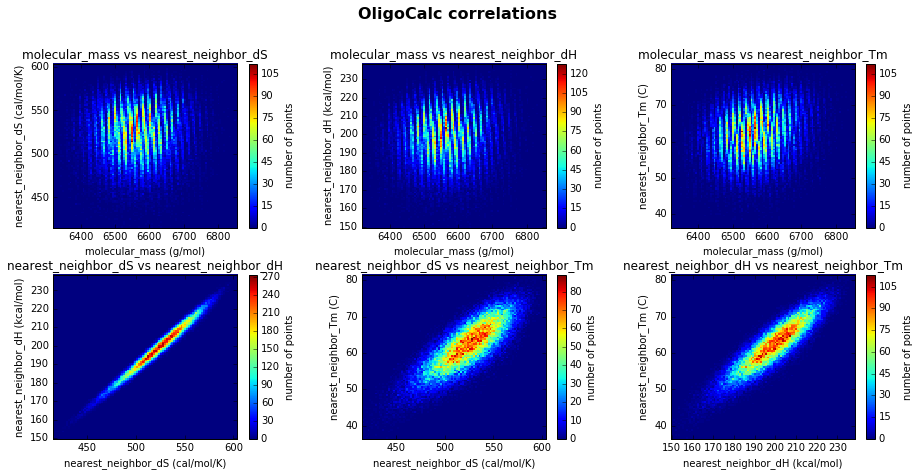

In [5]:
oligocalc_features = ['molecular_mass', 'nearest_neighbor_dS', 'nearest_neighbor_dH', 'nearest_neighbor_Tm']

with figure_grid(2, 2, 'OligoCalc features') as fig:
    feature_histograms(oligocalc_features, fig)
    
with figure_grid(2, 3, 'OligoCalc correlations') as fig:
    compare_feature_combinations(oligocalc_features, fig)

Note the strong correlation between `dH` and `dS`, and the relative independence of `molecular_mass`.

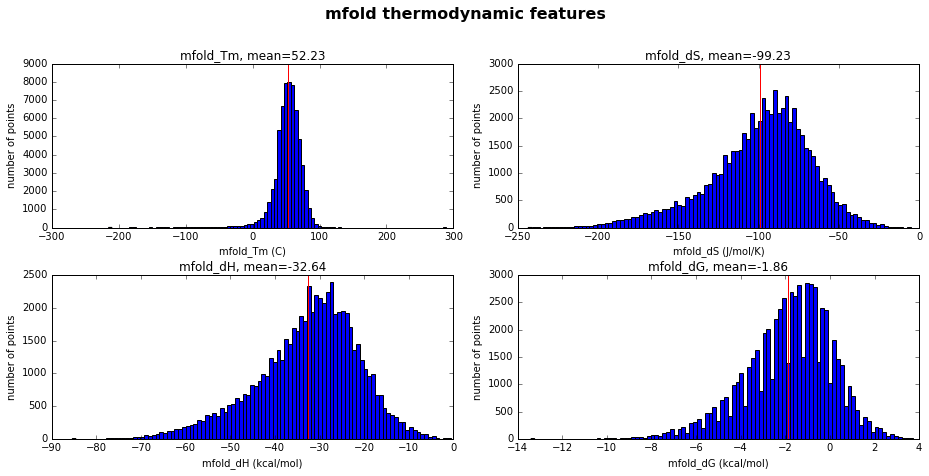

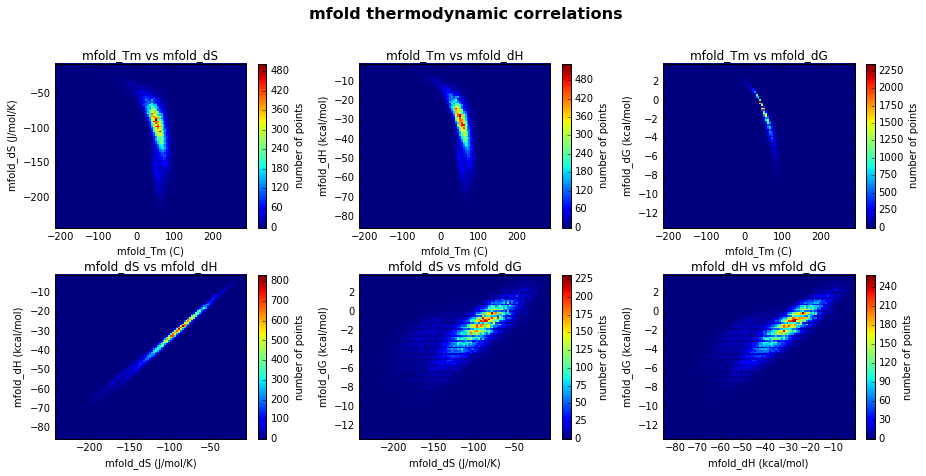

In [6]:
mfold_thermodynamic_features = ['mfold_Tm', 'mfold_dS', 'mfold_dH', 'mfold_dG']

with figure_grid(2, 2, 'mfold thermodynamic features') as fig:
    feature_histograms(mfold_thermodynamic_features, fig)

with figure_grid(2, 3, 'mfold thermodynamic correlations') as fig:
    compare_feature_combinations(mfold_thermodynamic_features, fig)

Here we can see some pretty strong correlations between many of these features, especially `dS`-`dH` and `Tm`-`dG`, and with weaker but still apparent ones between all the others.

One issue here is that the mfold and OligoCalc results don't really agree, at all. I don't think this is an artifact of my code wrapping and replicating them (respectively) -- even using their web interfaces, you still get the same disagreement. Perhaps they point to different things; e.g., maybe the mfold results are returning thermodynamic properties for a particular RNA folding, while the OligoCalc results are returning them for the entire RNA. I don't understand the underlying chemistry well enough yet to really analyze this.

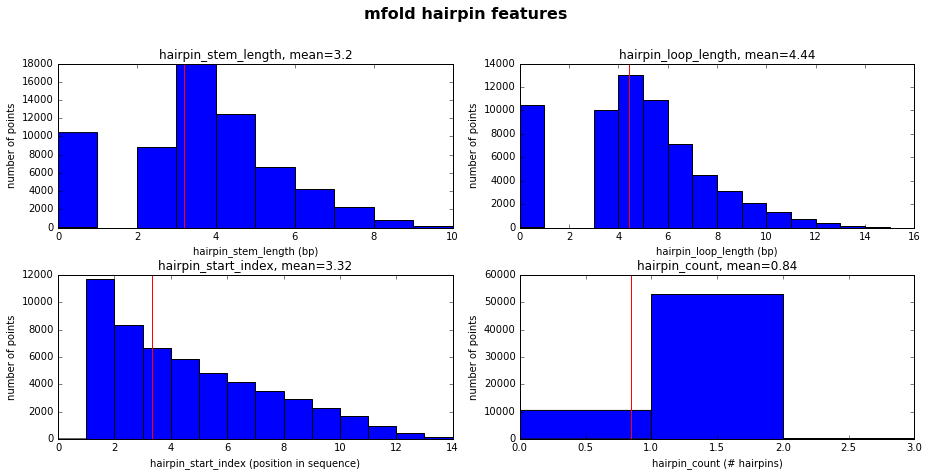

In [7]:
with figure_grid(2, 2, 'mfold hairpin features') as fig:
    fig.next_subplot(); feature_histogram('hairpin_stem_length', bins=10)
    fig.next_subplot(); feature_histogram('hairpin_loop_length', bins=15)
    fig.next_subplot(); feature_histogram('hairpin_start_index', xrng=(0, 14), bins=14)
    fig.next_subplot(); feature_histogram('hairpin_count', xrng=(0, 3), bins=3)

These are my naive attempts at representing hairpin attributes as numeric features suitable for classification/regression problems. "Start index" is the position in the gRNA where the hairpin starts, starting from the beginning of the string. Hopefully "stem length" and "loop length" are self-explanatory.

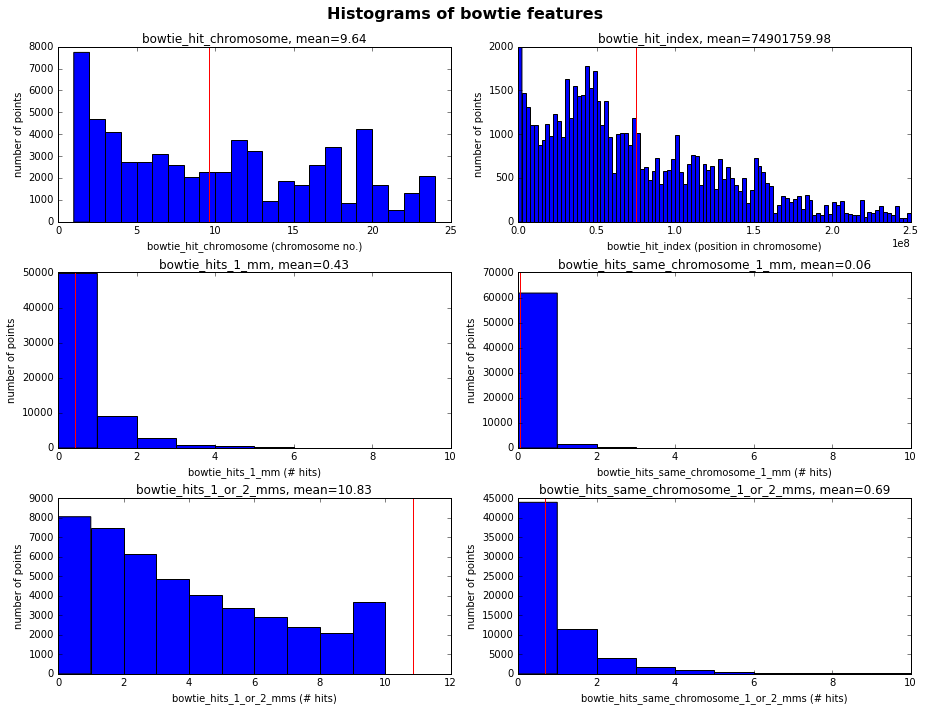

In [8]:
with figure_grid(3, 2, 'Histograms of bowtie features') as fig:
    fig.next_subplot(); feature_histogram('bowtie_hit_chromosome', bins=23, xrng=(1,24))
    fig.next_subplot(); feature_histogram('bowtie_hit_index', xrng=(0,2.5e8))
    fig.next_subplot(); feature_histogram('bowtie_hits_1_mm', bins=10, xrng=(0,10))
    fig.next_subplot(); feature_histogram('bowtie_hits_same_chromosome_1_mm', bins=10, xrng=(0,10))
    fig.next_subplot(); feature_histogram('bowtie_hits_1_or_2_mms', bins=10, xrng=(0,10))
    fig.next_subplot(); feature_histogram('bowtie_hits_same_chromosome_1_or_2_mms', bins=10, xrng=(0,10))

Note that in the "chromosome" graph, I mapped "X" to 23 and "Y" to 24 so they could be graphed using the normal, numeric histogram.

For more details about the Bowtie features, see [Validating Bowtie Results](validating-bowtie-results.ipynb).

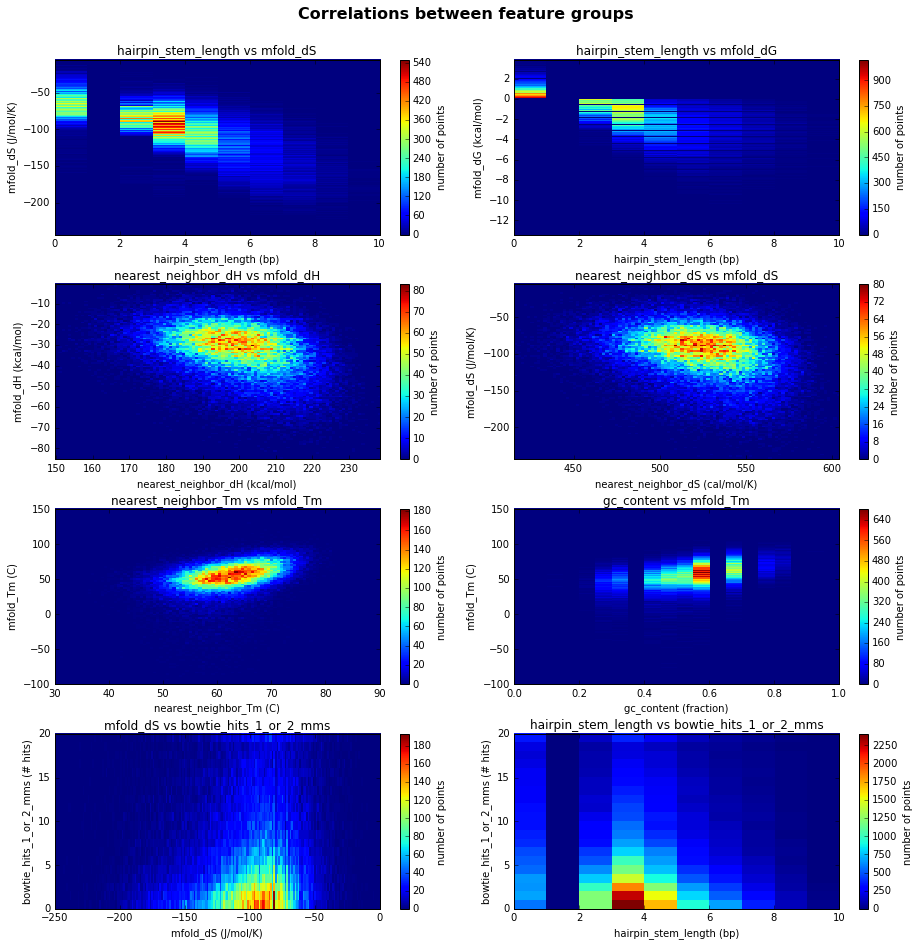

In [9]:
with figure_grid(4, 2, 'Correlations between feature groups') as fig:
    fig.next_subplot()
    compare_features('hairpin_stem_length', 'mfold_dS', bins=(10,200))
    fig.next_subplot()
    compare_features('hairpin_stem_length', 'mfold_dG', bins=(10,200))
    fig.next_subplot()
    compare_features('nearest_neighbor_dH', 'mfold_dH')
    fig.next_subplot()
    compare_features('nearest_neighbor_dS', 'mfold_dS')
    fig.next_subplot()
    compare_features('nearest_neighbor_Tm', 'mfold_Tm', xrng=((30,90), (-100,150)))
    fig.next_subplot()
    compare_features('gc_content', 'mfold_Tm', bins=(20,200), xrng=((0,1), (-100,150)))
    fig.next_subplot()
    compare_features('mfold_dS', 'bowtie_hits_1_or_2_mms', bins=(200, 20), xrng=((-250, 0),(0,20)))
    fig.next_subplot()
    compare_features('hairpin_stem_length', 'bowtie_hits_1_or_2_mms', bins=(10, 20), xrng=((0, 10),(0,20)))

For the most part, there don't seem to be terribly strong correlations between many of the different features (except maybe the mfold thermodynamic and mfold hairpin features, which makes sense because they clearly should be related). This suggests that we can probably use at least one feature from every feature group together as inputs to a classifier or regressor, because each contains information not present in the others.